## Dataset loading

### Regular dataset loading

In [ ]:
from python_proj.utils.util import safe_save_fig, Counter
import python_proj.utils.exp_utils as exp_utils

# Defines a number of constants.

file_name = "dataset_transformed"
base_path = exp_utils.BASE_PATH
data_path = f"{base_path}/final_data/{file_name}.csv"
figure_base_path = f"{base_path}/figures/modelling/{file_name}/rf_ftc/"

# Meta stuff.
pr_merged_key = "PullRequestIsMerged"
ftc_key = "SubmitterIsFirstTimeContributor"
seed_counter = Counter()

In [10]:
import pandas as pd
import numpy as np
import json


# Loads regular dataframe.
df: pd.DataFrame = pd.read_csv(filepath_or_buffer=data_path, header=0)

# Creates sub-datasets.
metadata_fields = ["ID", "Project Name", "Submitter ID", "PR Number", "Closed At"]
dependent_fields = [pr_merged_key]

df.describe()

class_imbalance=3.7022064651322837


In [ ]:
# Identifieds independent / predictor fields.


def is_independent_field(field: str) -> bool:
    return field not in metadata_fields and field != pr_merged_key


independent_fields = list(filter(is_independent_field, df.columns))

In [ ]:
# Calculates class imbalance.
class_counts = df[pr_merged_key].value_counts()
class_imbalance = class_counts[True] / class_counts[False]
print(f"{class_imbalance=}")

## Model Creation

### Re-usable Functions

To create a random forest model and to perform k-fold cross validation.

In [3]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (
    f1_score,
    confusion_matrix,
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
)


def calculate_metrics(predicted_labels, true_labels, sample_weights=None):
    return {
        "accuracy": accuracy_score(
            true_labels, predicted_labels, sample_weight=sample_weights
        ),
        "precision": precision_score(
            true_labels, predicted_labels, sample_weight=sample_weights
        ),
        "recall": recall_score(
            true_labels, predicted_labels, sample_weight=sample_weights
        ),
        "f1": f1_score(true_labels, predicted_labels, sample_weight=sample_weights),
    }


def create_model(
    train_predictors: pd.DataFrame,
    train_labels: pd.Series,
    test_predictors: pd.DataFrame,
    test_labels: pd.Series,
    random_state: int | None = None,
):
    # Model creation and predictions.
    if random_state is None:
        random_state = seed_counter.get_next()
    print(f"{random_state=}")
    rf = RandomForestRegressor(n_estimators=100, random_state=random_state)

    rf.fit(train_predictors, train_labels)

    predictions = rf.predict(test_predictors)
    predictions = [pred >= 0.5 for pred in predictions]

    # F1 scores.
    conf = confusion_matrix(test_labels, predictions)

    metrics = calculate_metrics(predictions, test_labels)

    print(f"{metrics=}\n")

    # Other metrics.
    print(f"Confusion matrix:\n{conf}\n")
    print("Classification report:")
    print(classification_report(test_labels, predictions))

    return rf, metrics

In [4]:
from typing import Iterator
import regex as re
from sklearn.model_selection import KFold
from python_proj.utils.mt_utils import parallelize_tasks


def kfold_rf_evaluation(_df: pd.DataFrame, predictor_fields: Iterator[str], k: int = 5):
    random_state = seed_counter.get_next()

    def create_model_for_fold(task, *args, **kwargs):
        train_idx, test_idx = task
        train = _df.loc[train_idx, :]
        test = _df.loc[test_idx, :]
        train_predictors = train[predictor_fields]
        train_labels = train[pr_merged_key]
        test_predictors = test[predictor_fields]
        test_labels = test[pr_merged_key]
        _, rf_metrics = create_model(
            train_predictors, train_labels, test_predictors, test_labels, random_state
        )
        return rf_metrics

    kf = KFold(n_splits=k, shuffle=True, random_state=seed_counter.get_next())
    tasks = kf.split(_df)
    models_and_f1s = parallelize_tasks(
        tasks,
        create_model_for_fold,
        thread_count=min(k, 12),
        return_results=True,
        print_lifetime_events=False,
    )

    f1_scores = [entry["f1"] for entry in models_and_f1s]
    f1_mean = np.mean(f1_scores)
    f1_std = np.std(f1_scores)

    return f1_scores, f1_mean, f1_std

### Full Model

In [5]:
f1_scores, f1_mean, f1_std = kfold_rf_evaluation(df, independent_fields)

print("\nPerformance metrics full model:")
print(f"{f1_scores=}")
print(f"{f1_mean=}, {f1_std=}")

random_state=43
random_state=43
random_state=43random_state=43

random_state=43
metrics={'accuracy': 0.7686930339491405, 'precision': 0.7942745692225858, 'recall': 0.8747270693909431, 'f1': 0.8325617544689622}

Confusion matrix:
[[16591 12763]
 [ 7057 49276]]

Classification report:
              precision    recall  f1-score   support

       False       0.70      0.57      0.63     29354
        True       0.79      0.87      0.83     56333

    accuracy                           0.77     85687
   macro avg       0.75      0.72      0.73     85687
weighted avg       0.76      0.77      0.76     85687

metrics={'accuracy': 0.7708197180468677, 'precision': 0.7943133890341101, 'recall': 0.879097669630655, 'f1': 0.8345577085088458}

Confusion matrix:
[[16519 12826]
 [ 6812 49531]]

Classification report:
              precision    recall  f1-score   support

       False       0.71      0.56      0.63     29345
        True       0.79      0.88      0.83     56343

    accuracy          

### Control + Intra-project Model

In [6]:
from python_proj.utils.util import get_matching

ci_re = r".*(Control|Intra).*"
contr_with_intra = list(get_matching(independent_fields, ci_re))
print(contr_with_intra)

f1_scores, f1_mean, f1_std = kfold_rf_evaluation(df, contr_with_intra)

print("\nPerformance metrics control + intra model:")
print(f"{f1_scores=}")
print(f"{f1_mean=}, {f1_std=}")

['ControlIntegratedBySameUser', 'ControlPullRequestHasComments', 'ControlHasHashTagInDescription', 'IntraProjectSubmitterPullRequestSuccessRate', 'ControlPullRequestHasCommentByExternalUser', 'ln(1 + ControlPullRequestLifeTimeInMinutes)', 'ln(1 + ControlNumberOfCommitsInPullRequest)', 'ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)', 'ln(1 + IntraProjectSubmitterPullRequestSubmissionCount)', 'ln(1 + IntraProjectSubmitterPullRequestCommentCount)', 'ln(1 + IntraProjectSubmitterIssueSubmissionCount)', 'ln(1 + IntraProjectSubmitterIssueCommentCount)']
random_state=45random_state=45random_state=45


random_state=45
random_state=45
metrics={'accuracy': 0.737836544633375, 'precision': 0.7823128125310461, 'recall': 0.8352839261721237, 'f1': 0.8079310521725748}

Confusion matrix:
[[15976 13147]
 [ 9317 47247]]

Classification report:
              precision    recall  f1-score   support

       False       0.63      0.55      0.59     29123
        True       0.78      0.84      0

### Collaboration and Ecosystem Model

In [7]:
from python_proj.utils.util import get_non_matching

non_control_intra_fields = list(get_non_matching(independent_fields, ci_re))
print(non_control_intra_fields)

f1_scores, f1_mean, f1_std = kfold_rf_evaluation(df, non_control_intra_fields)

print("\nPerformance metrics non-control model:")
print(f"{f1_scores=}")
print(f"{f1_mean=}, {f1_std=}")

['EcosystemExperienceSubmitterPullRequestSuccessRate', 'DependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'ln(1 + EcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + EcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + EcosystemExperienceSubmitterIssueSubmissionCount)', 'ln(1 + EcosystemExperienceSubmitterIssueCommentCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterIssueSubmissionCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterIssueCommentCount)', 'ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueSubmissionCount)', 'ln(1 + InversedDependencyEcosyste

## Feature Explanation and Evaluation

### Partial Dependence Plots

In [8]:
from sklearn.inspection import PartialDependenceDisplay
from matplotlib import pyplot as plt


def create_partial_dependence_plots(
    rf_model: RandomForestRegressor, used_predictors: pd.DataFrame, model_name: str = ""
):
    # Collective partial dependence plot.
    PartialDependenceDisplay.from_estimator(
        rf_model, used_predictors, used_predictors.columns, percentiles=(0.01, 0.99)
    )

    fig = plt.gcf()
    axs = fig.axes

    lines = []
    for ax in axs:
        __lines = list([(line.get_xdata(), line.get_ydata()) for line in ax.lines])
        lines.extend(__lines)

    for (x, y), label in zip(lines, used_predictors.columns):
        plt.clf()
        plt.plot(x, y, linestyle="-", color="#e69d00")
        plt.xlabel(label)
        plt.ylabel("Partial Dependence")
        plt.tight_layout()
        output_path = f"{figure_base_path}/partial-dependence/{model_name}/{label}.png"
        safe_save_fig(output_path)

In [5]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2, shuffle=True)
train_predictors = train[independent_fields]
train_dependent = train[pr_merged_key]
test_predictors = test[independent_fields]
test_dependent = test[pr_merged_key]

In [6]:
full_rf_model, _ = create_model(
    train_predictors, train_dependent, test_predictors, test_dependent
)

create_partial_dependence_plots(full_rf_model, test_predictors, model_name="full_model")

random_state=43
metrics={'accuracy': 0.7681355615722155, 'precision': 0.7934480039904102, 'recall': 0.8752107626501962, 'f1': 0.8323262329946326}

Confusion matrix:
[[16508 12837]
 [ 7031 49312]]

Classification report:
              precision    recall  f1-score   support

       False       0.70      0.56      0.62     29345
        True       0.79      0.88      0.83     56343

    accuracy                           0.77     85688
   macro avg       0.75      0.72      0.73     85688
weighted avg       0.76      0.77      0.76     85688



NameError: name 'create_partial_dependence_plots' is not defined

### Mean decrease in Impurity

/tmp/ipykernel_6335/2882849337.py:14: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


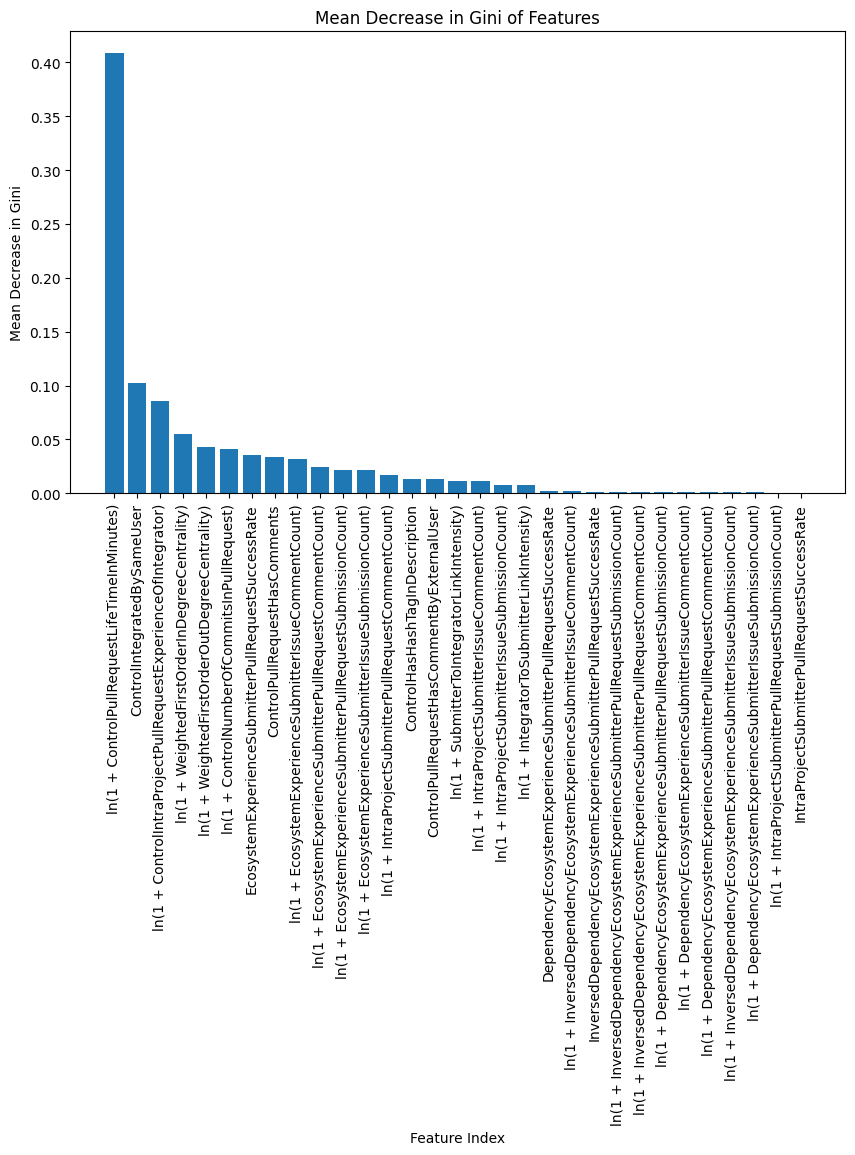

ln(1 + ControlPullRequestLifeTimeInMinutes): 0.4083
ControlIntegratedBySameUser: 0.1020
ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator): 0.0853
ln(1 + WeightedFirstOrderInDegreeCentrality): 0.0553
ln(1 + WeightedFirstOrderOutDegreeCentrality): 0.0426
ln(1 + ControlNumberOfCommitsInPullRequest): 0.0408
EcosystemExperienceSubmitterPullRequestSuccessRate: 0.0352
ControlPullRequestHasComments: 0.0335
ln(1 + EcosystemExperienceSubmitterIssueCommentCount): 0.0322
ln(1 + EcosystemExperienceSubmitterPullRequestCommentCount): 0.0241
ln(1 + EcosystemExperienceSubmitterPullRequestSubmissionCount): 0.0220
ln(1 + EcosystemExperienceSubmitterIssueSubmissionCount): 0.0219
ln(1 + IntraProjectSubmitterPullRequestCommentCount): 0.0170
ControlHasHashTagInDescription: 0.0131
ControlPullRequestHasCommentByExternalUser: 0.0130
ln(1 + SubmitterToIntegratorLinkIntensity): 0.0118
ln(1 + IntraProjectSubmitterIssueCommentCount): 0.0113
ln(1 + IntraProjectSubmitterIssueSubmissionCount): 0.0078
ln(1 +

In [7]:
feature_importances = full_rf_model.feature_importances_

sorted_indices = np.argsort(feature_importances)[::-1]
sorted_importances = feature_importances[sorted_indices]

# Step 4: Plot the mean decrease accuracy plot
plt.figure(figsize=(10, 6))
plt.bar(range(test_predictors.shape[1]), sorted_importances)
plt.xlabel("Feature Index")
plt.ylabel("Mean Decrease in Gini")
plt.title("Mean Decrease in Gini of Features")
ordererd_columns = np.array(test_predictors.columns)[sorted_indices]
plt.xticks(range(test_predictors.shape[1]), ordererd_columns, rotation=90)
plt.tight_layout()
plt.show()

for field, importance in zip(ordererd_columns, sorted_importances):
    print(f"{field}: {importance:.04f}")

### Variable Group Ablation Studies

Performs an ablation and a reverse ablation study using different feature groups:
- control variables
- intra-project experience
- ecosystem experience
- dependency ecosystem experience
- inverse dependency ecosystem experience
- non-dependency ecosystem experience
- collaboration variables

In [12]:
from python_proj.utils.util import get_matching

# Generates variable groups

var_group_regex_patterns = [
    ("control", r".*Control.*"),
    ("intra", r"^(?!.*Control).*(?=Intra).*"),
    ("eco", r"^(?!.*Dependency).*(?=Ecosystem).*"),
    ("deco", r"^(?!.*(Inverse|Non)).*(?=Dependency).*"),
    ("ideco", r".*(?=Inverse).*"),
    ("ndeco", r".*(?=NonDependency).*"),
    ("coll", r".*(Weighted|LinkIntensity).*"),
]

var_groups = [
    (name, list(get_matching(pattern, independent_fields)))
    for (name, pattern) in var_group_regex_patterns
]

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/vscode/.local/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3505, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_8785/3025803600.py", line 15, in <module>
    var_groups = [
                 ^
  File "/tmp/ipykernel_8785/3025803600.py", line 16, in <listcomp>
    (name, list(get_matching(pattern, independent_fields)))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/workspaces/msc_thesis/python_proj/utils/util.py", line 370, in __matches_pattern
  File "/home/vscode/.local/lib/python3.11/site-packages/regex/regex.py", line 253, in match
    pat = _compile(pattern, flags, ignore_unused, kwargs, True)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/vscode/.local/lib/python3.11/site-packages/regex/regex.py", line 468, in _compile
    if _locale_sensitive.get(locale_key, True) or (flags & LOCALE) != 0:
       ^^^^^^^^^^^^^^^^^^^^

#### Regular Ablation
Creates models with subsets of the features to test their impact on the predictions in isolation.

In [12]:
abl_results = dict()

for cluster_name, cluster in var_groups:
    used_fields = list([field for field in independent_fields if field not in cluster])
    print(
        f'Ablation with "{cluster_name}", excluding: {list(cluster)}, including: {used_fields}.'
    )

    # Creates models
    f1_scores, f1_mean, f1_std = kfold_rf_evaluation(df, cluster)
    abl_results[cluster_name] = (f1_scores, f1_mean, f1_std)

    print(
        f"Performance of '{cluster_name}'\n{list(cluster)}\n{f1_scores=}\n{f1_mean=}, {f1_std=}\n"
    )


# Prints summarized results again for clarity.
for cluster_name, (f1_scores, f1_mean, f1_std) in abl_results.items():
    print(
        f"Cluster '{cluster_name}':\n{f1_scores=:.4d}\n{f1_mean=:.4d}, {f1_std=:.4d}\n"
    )

Starting cluster ablation with "control" fields excluded: ['ControlIntegratedBySameUser', 'ControlPullRequestHasComments', 'ControlHasHashTagInDescription', 'ControlPullRequestHasCommentByExternalUser', 'ln(1 + ControlPullRequestLifeTimeInMinutes)', 'ln(1 + ControlNumberOfCommitsInPullRequest)', 'ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)'].
random_state=50
random_state=50
random_state=50
random_state=50
random_state=50
metrics={'accuracy': 0.7255593030448027, 'precision': 0.7741387069353468, 'recall': 0.8233500558401731, 'f1': 0.7979863926877879}

Confusion matrix:
[[15725 13551]
 [ 9965 46446]]

Classification report:
              precision    recall  f1-score   support

       False       0.61      0.54      0.57     29276
        True       0.77      0.82      0.80     56411

    accuracy                           0.73     85687
   macro avg       0.69      0.68      0.69     85687
weighted avg       0.72      0.73      0.72     85687

metrics={'accuracy': 0.7248

#### Reverse ablation

Performs a reverse ablation study, such that models are created using ONLY the subset of variables.

In [ ]:
rev_abl_results = dict()

for cluster_name, cluster in var_groups:
    print(f'Reverse ablation with "{cluster_name}", including: {list(cluster)}.')

    # Creates models
    f1_scores, f1_mean, f1_std = kfold_rf_evaluation(df, cluster)
    rev_abl_results[cluster_name] = (f1_scores, f1_mean, f1_std)

    print(
        f"Performance of '{cluster_name}'\n{list(cluster)}\n{f1_scores=}\n{f1_mean=}, {f1_std=}\n"
    )

# Prints summarized results again for clarity.
for cluster_name, (f1_scores, f1_mean, f1_std) in rev_abl_results.items():
    print(
        f"Cluster '{cluster_name}':\n{f1_scores=:.4d}\n{f1_mean=:.4d}, {f1_std=:.4d}\n"
    )

### Probability Guesser

Guesses the outcome by simply considering the probability of a merged pull request.
Technically, an RF model performs somewhat well when its performance scores are ``> 0.5`` as there are only two possible outcomes.
However, they actually mean anything once it's better than a simple probability guesser.

In [13]:
import random

random.seed(seed_counter.get_next())

probability_true = class_imbalance / (class_imbalance + 1)

predictions = [random.random() < probability_true for _ in range(len(test_dependent))]
metrics = calculate_metrics(predictions, test_dependent)

print(f"Probability guesser metrics with {probability_true=:.03f}.")
print(json.dumps(metrics, indent=4))

Probability guesser metrics with probability_true=0.659.
{
    "accuracy": 0.5518975819251237,
    "precision": 0.6598624991140407,
    "recall": 0.6598040431601141,
    "f1": 0.6598332698423949
}
